<a href="https://colab.research.google.com/github/ofakduman/Acme-Hired-Web-App/blob/main/lstm_forecasting_v3_encoder_decoder_filtered.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
df = pd.read_csv("/content/drive/MyDrive/LSTM_forecasting/all_data.csv")
len(df)

24194

In [126]:
df.replace("Not available", pd.NA, inplace=True)
len(df)


24194

In [127]:
df_dropped = df.drop(['Conditions', 'Assumed', 'Max.rate(logc.conc / h)', 'Food Name'], axis=1)
df_dropped.head()
len(df_dropped.dropna())

10078

In [128]:
df_dropped.dropna(inplace=True)
len(df_dropped)
cleaned_df = df_dropped.drop_duplicates(subset='Record ID', keep='first')

### logcs nan olanlari at, record ID tekrarlanmasin
### Food name kolonunu kaldir
### Temperature Nan lari kaldir ve temprature kolonundaki logcs degerleri gibi olan degerleri kaldir deger int e cevriliyorsa kalsin
### Nanlari kaldir Aw deki
### Assumed kolonunu kaldir
### Conditions kolonunu kaldir
### Max.rate(logc.conc / h) kolonunu kaldir

In [129]:
def analyze_logcs(logcs_str):
    # Değerleri ; ile böl ve float'a çevir
    values = list(map(float, logcs_str.split(';')))

    # Zaman ve populasyon değerlerini ayır
    times = values[::2]
    populations = values[1::2]

    # Populasyon değerlerinin artıp artmadığını kontrol et
    increases = 0
    decreases = 0
    for i in range(1, len(populations)):
        if populations[i] > populations[i-1]:
            increases += 1
        elif populations[i] < populations[i-1]:
            decreases += 1

    # Toplam değer sayısı ve artma/azalma sayılarına göre bir sonuç döndür
    return {
        "total_values": len(populations),
        "increases": increases,
        "decreases": decreases
    }

# `Logcs` kolonunu analiz edelim
cleaned_df_copy = cleaned_df.copy()
results = cleaned_df['Logcs'].apply(analyze_logcs)

# Sonuçları yeni kolonlarda saklayalım
cleaned_df_copy['Total Values'] = results.apply(lambda x: x["total_values"])
cleaned_df_copy['Increases'] = results.apply(lambda x: x["increases"])
cleaned_df_copy['Decreases'] = results.apply(lambda x: x["decreases"])

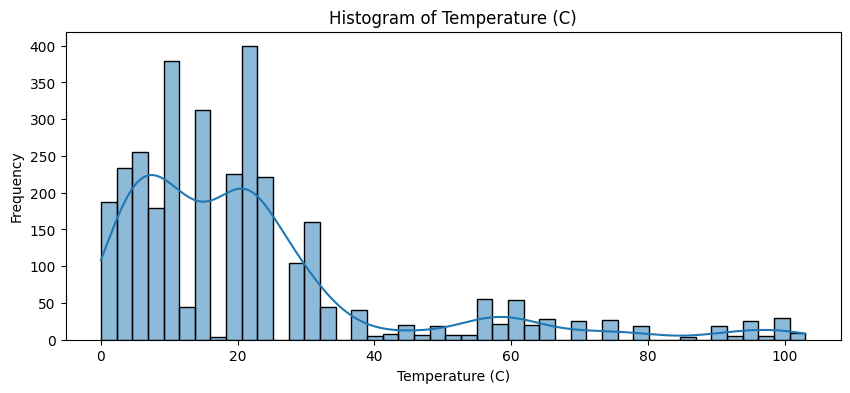


Temperature (C) - Statistical Species:
Min: 0.0
Max: 103.0
Mean: 22.02159850140493
Median: 19.58


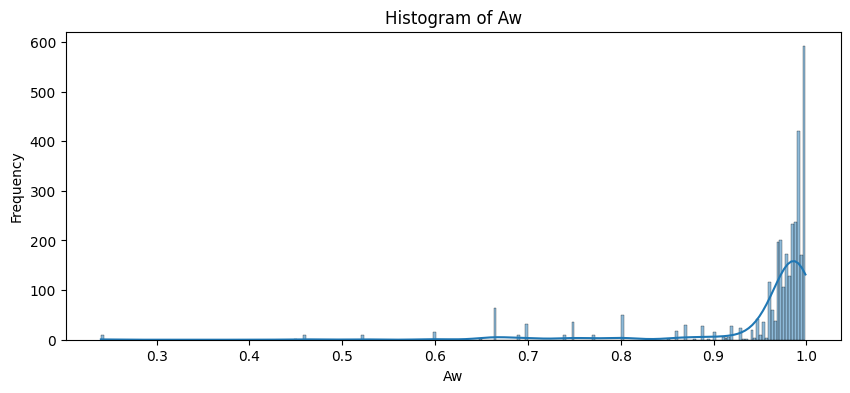


Aw - Statistical Species:
Min: 0.24
Max: 0.999
Mean: 0.955194817358726
Median: 0.986


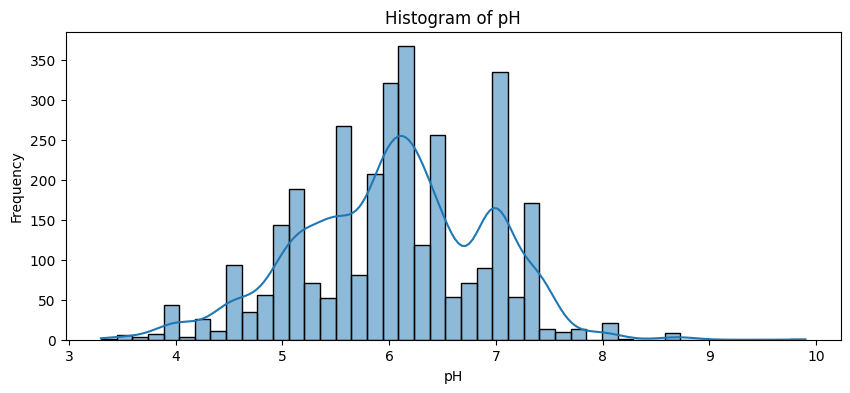


pH - Statistical Species:
Min: 3.3
Max: 9.9
Mean: 6.048773025288792
Median: 6.0


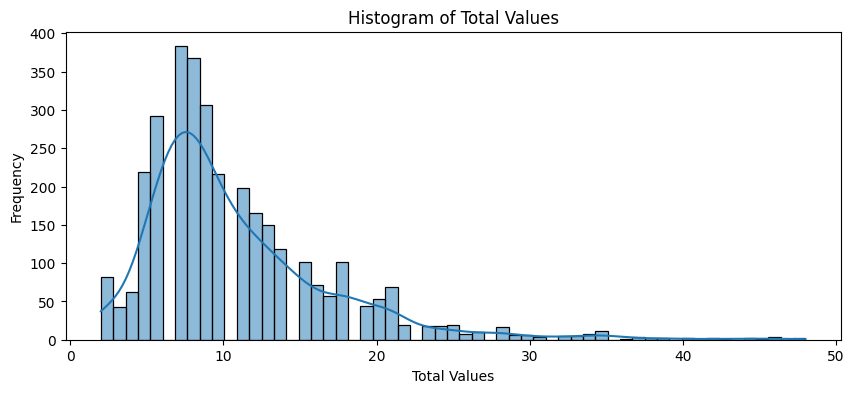


Total Values - Statistical Species:
Min: 2
Max: 48
Mean: 10.848993288590604
Median: 9.0


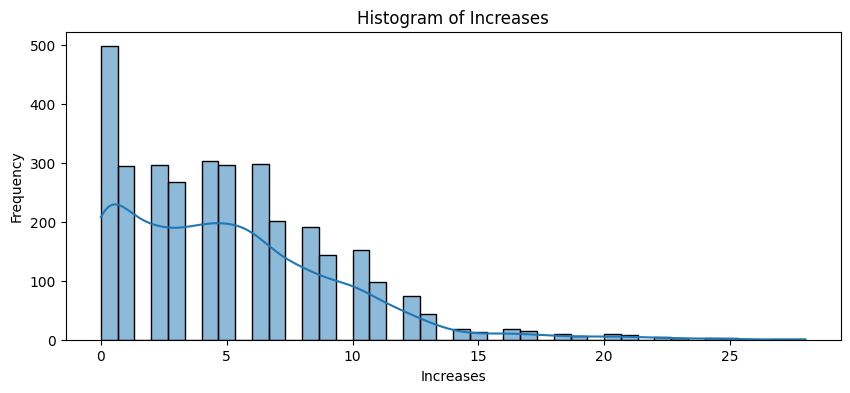


Increases - Statistical Species:
Min: 0
Max: 28
Mean: 5.041488712629652
Median: 4.0


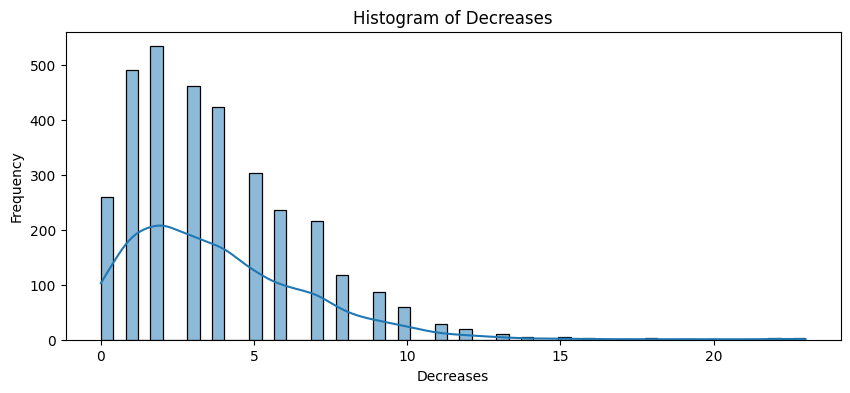


Decreases - Statistical Species:
Min: 0
Max: 23
Mean: 3.8550945698596704
Median: 3.0


In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest

# Veri setinizi yükleyin
# cleaned_df_copy = pd.read_csv('your_dataset.csv')  # Örnek veri seti yolu
# Sayısal sütunları seçin (örnek olarak sadece sayısal verileri içeren sütunlar listelenmiştir)
numeric_columns = ['Temperature (C)', 'Aw', 'pH', 'Total Values', 'Increases', 'Decreases']
for col in numeric_columns:
    # Sayısal olmayan verileri ve NaN değerleri temizle
    cleaned_data = cleaned_df_copy[col].apply(pd.to_numeric, errors='coerce').dropna()
    squared_data = cleaned_data ** 2

    # Histogramı çiz
    plt.figure(figsize=(10, 4))
    sns.histplot(cleaned_data, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

    # Temel İstatistiksel Özellikler
    print(f"\n{col} - Statistical Species:")
    print(f"Min: {cleaned_data.min()}")
    print(f"Max: {cleaned_data.max()}")
    print(f"Mean: {cleaned_data.mean()}")
    print(f"Median: {cleaned_data.median()}")




In [131]:
trashold_sample_value = 5
df = cleaned_df_copy[cleaned_df_copy['Total Values'] > trashold_sample_value]
df = df[df['Temperature (C)'].apply(lambda x: ';' not in x)]
df = df[df['pH'].apply(lambda x: ';' not in x)]
df = df[df['Aw'].apply(lambda x: ';' not in x)]
len(df)

2806

In [132]:
def parse_logcs(logcs_str):
    pairs = logcs_str.split(';')
    parsed_pairs = []
    for i in range(0, len(pairs) - 1, 2):
        try:
            # Zaman değerini tam sayıya dönüştür
            time = float(pairs[i])
            # Değer olarak ondalık sayı kullan
            value = float(pairs[i + 1])
            parsed_pairs.append((time, value))
        except ValueError:
            # Geçersiz dönüşüm olduğunda bu çifti atla
            continue
    return parsed_pairs

df['Logcs'] = df['Logcs'].apply(parse_logcs)


In [91]:
# # Yeni filtre
# def parse_logcs(logcs_str):
#     # String ifadeyi parçalayarak liste haline getir
#     try:
#         # Kötü niyetli kodların çalıştırılmasını önlemek için güvenli bir yol kullanılıyor
#         logcs_list = eval(logcs_str, {'__builtins__': None}, {})
#     except:
#         logcs_list = []

#     # 0 değerlerinin sayısını hesapla
#     zero_count = sum(1 for _, value in logcs_list if value == 0)
#     return zero_count

# # Yeni bir sütun ekleyerek her satır için 0 değerlerinin sayısını hesapla
# df['Zero_Count'] = df['Logcs'].apply(parse_logcs)

# # 1'den fazla 0 değerine sahip olanları at
# df = df[df['Zero_Count'] <= 1]

# # Decreases, Increases'tan fazla olanları at
# df = df[df['Decreases'] <= df['Increases']]

# # Total Values 8'den büyük olanları seç
# df = df[df['Total Values'] > 8]



In [92]:
# #BlackList
# import numpy as np
# anomalies_path = "/content/drive/MyDrive/LSTM_forecasting/anomalies.npy"
# loaded_anomalies = np.load(anomalies_path)
# df_filtered = df[~df['Record ID'].isin(loaded_anomalies)]


In [133]:
import pandas as pd

# DataFrame'inizi yükleyin (örnek: df = pd.read_csv("your_dataframe.csv"))

# Blacklist DataFrame'lerini yükle
blacklist_dfs = []
for i in range(2, 11):  # 2'den 8'e kadar (dahil) olan dosyalar için
    path = f"/content/drive/MyDrive/LSTM_forecasting/anomalies{i}.csv"
    blacklist_df = pd.read_csv(path, header=None)
    blacklist_dfs.append(blacklist_df)

# Tüm blacklist'leri birleştir
combined_blacklist = pd.concat(blacklist_dfs)[0].tolist()

# 'Record ID' sütununun olduğundan emin olun
if 'Record ID' in df.columns:
    # Blacklist'teki Record ID'leri içermeyen satırları filtrele
    df = df[~df['Record ID'].isin(combined_blacklist)]
else:
    print("DataFrame does not have 'Record ID' column.")

# Filtrelenmiş DataFrame'in uzunluğunu yazdır
len(df)


508

In [134]:
import joblib
original_columns = set(df.columns)

df = pd.get_dummies(df, columns=['Organism', 'Food category'])
all_columns = df.columns
joblib.dump(all_columns, 'model_columns.pkl')


['model_columns.pkl']

In [135]:
import joblib
from sklearn.preprocessing import StandardScaler


features_to_scale = ['Temperature (C)', 'Aw', 'pH']
scaler = StandardScaler()

# Normalizasyonu sadece belirli sütunlara uygula
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [136]:
import pandas as pd
import numpy as np


# Hariç tutulacak sütunlar
exclude_columns = ['Record ID','Total Values', 'Increases', 'Decreases','Logcs', 'Zero_Count']

# all_features listesini oluşturma
all_features = [col for col in df.columns if col not in exclude_columns]

# Veriyi hazırlama
X = []  # Girdiler
y = []  # Hedefler

for index, row in df.iterrows():
    logcs_data = row['Logcs']
    # Tüm uygun özellikleri al
    features = row[all_features].values
    for i in range(len(logcs_data)-1):
        X.append(np.concatenate(([logcs_data[i][1]], features)))  # current value and other features
        y.append(logcs_data[i+1][1])  # next value

X = np.array(X).reshape(-1, 1, len(X[0]))  # (samples, time steps, features)
y = np.array(y).reshape(-1, 1)

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Verilerinizi yükleyin veya oluşturun
# X ve y verilerini bu aşamada hazırlayın

# Verileri eğitim ve test kümesine bölün
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [137]:
from sklearn.model_selection import train_test_split
X = []
Y = []

# X_RecordID ve Y_RecordID listelerini oluşturma
X_RecordID = []
Y_RecordID = []

for index, row in df.iterrows():
    record_id = row['Record ID']
    logcs_data = row['Logcs']

    # Tüm uygun özellikleri al
    features = row[all_features].values
    for i in range(len(logcs_data)-1):
        X.append(np.concatenate(([logcs_data[i][1]], features)))
        Y.append(logcs_data[i+1][1])  # Y listesini kullan

        # RecordID'leri ekleme
        X_RecordID.append(record_id)
        Y_RecordID.append(record_id)

# Numpy dizilerine dönüştürme
X = np.array(X).reshape(-1, 1, len(X[0]))
Y = np.array(Y).reshape(-1, 1)  # Y dizisini numpy array'e çevirme
X_RecordID = np.array(X_RecordID)
Y_RecordID = np.array(Y_RecordID)

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, Y_train, Y_test, X_train_ids, X_test_ids, Y_train_ids, Y_test_ids = train_test_split(
    X, Y, X_RecordID, Y_RecordID, test_size=0.2, random_state=42
)


In [138]:

X_train

array([[[9.67, -0.22493488061525319, 0.4597804853585553, ..., 0, 0, 0]],

       [[7.48, 2.775580675744973, 0.23064526714872885, ..., 0, 0, 0]],

       [[3.48, -0.35352840445926287, 0.2804572711073868, ..., 0, 0, 0]],

       ...,

       [[2.72, -1.0093553760637122, 0.4597804853585553, ..., 0, 0, 0]],

       [[3.26, -0.8250379918872983, 0.39004367981643423, ..., 0, 0, 0]],

       [[4.37, 1.2753228975648598, 0.2605324695239236, ..., 0, 0, 0]]],
      dtype=object)

Epoch 1/30
218/218 [==============================] - 7s 10ms/step - loss: 28.3184 - val_loss: 21.4373
Epoch 2/30
218/218 [==============================] - 1s 4ms/step - loss: 13.9441 - val_loss: 8.7724
Epoch 3/30
218/218 [==============================] - 1s 4ms/step - loss: 6.7709 - val_loss: 5.6870
Epoch 4/30
218/218 [==============================] - 1s 4ms/step - loss: 4.7274 - val_loss: 4.3290
Epoch 5/30
218/218 [==============================] - 1s 4ms/step - loss: 3.5699 - val_loss: 3.1651
Epoch 6/30
218/218 [==============================] - 1s 4ms/step - loss: 2.6341 - val_loss: 2.4257
Epoch 7/30
218/218 [==============================] - 1s 4ms/step - loss: 1.9966 - val_loss: 1.9434
Epoch 8/30
218/218 [==============================] - 1s 4ms/step - loss: 1.6161 - val_loss: 1.6628
Epoch 9/30
218/218 [==============================] - 1s 4ms/step - loss: 1.3709 - val_loss: 1.4734
Epoch 10/30
218/218 [==============================] - 1s 5ms/step - loss: 1.1991 - val_loss: 1.

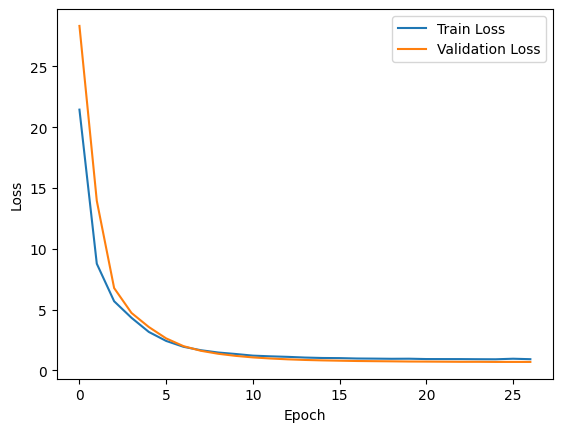

In [139]:

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# LSTM modeli oluşturun
model = keras.Sequential()
model.add(layers.LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(layers.LSTM(4, return_sequences=True, name='lstm_output'))
model.add(layers.Dense(1, name='dense_output'))  # Çıkış katmanı

# Modeli derleyin
model.compile(optimizer='adam', loss='mean_squared_error')  # İstediğiniz bir optimizasyon ve loss fonksiyonu kullanabilirsiniz

# Early Stopping callback'i oluşturun
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

# Modeli eğitin ve Early Stopping callback'ini kullanın
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Modelin performansını değerlendirin
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Tahminler yapın
predictions = model.predict(X_test)

# Eğitim ve doğrulama kayıplarını görselleştirin
plt.plot(history.history['val_loss'], label='Train Loss')
plt.plot(history.history['loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


In [140]:
model.save("one_step_ahead.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 2ms/step


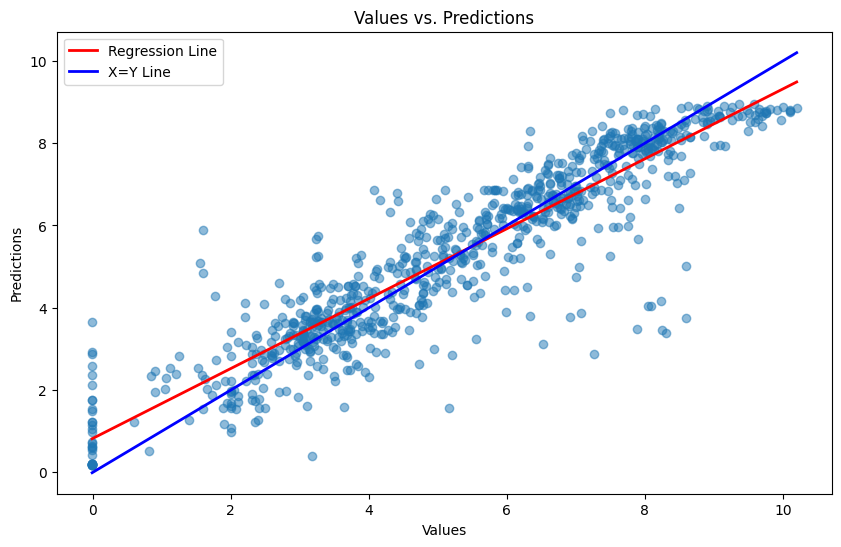

In [141]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Tahminleri ve gerçek değerleri alın
predictions = model.predict(X_test)

# Linear Regression modelini oluşturun ve eğitin
regression_model = LinearRegression()
y_test = y_test.reshape(-1, 1)  # Yeniden şekillendirme
predictions = predictions.reshape(-1, 1)  # Yeniden şekillendirme
regression_model.fit(y_test, predictions)

# Gerçek değerlerin minimum ve maksimum değerlerini alın
min_val = min(np.min(y_test), np.min(predictions))
max_val = max(np.max(y_test), np.max(predictions))

# Doğruyu çizmek için tahminler oluşturun
x_values = np.linspace(min_val, max_val, 100)
y_values = regression_model.predict(x_values.reshape(-1, 1))

# Scatter plot oluşturun
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot(x_values, y_values, color='red', linewidth=2, label='Regression Line')

# X=Y doğrusunu çizmek için
plt.plot([min_val, max_val], [min_val, max_val], color='blue', linewidth=2, label='X=Y Line')

plt.xlabel('Values')
plt.ylabel('Predictions')
plt.title('Values vs. Predictions')
plt.legend()
plt.show()


In [103]:


# # Anomali tespiti için hata eşiği belirleme
# hata_esigi = 2.3    # Bu değeri ihtiyaçlarınıza göre ayarlayın

# predictions = model.predict(X_train)


# # Anomali tespiti
# anomali_maskesi = np.abs(y_train.reshape(-1) - predictions.reshape(-1)) > hata_esigi

# # Anomali olarak tespit edilen örneklerin RecordID'lerini alın
# anomali_record_ids = X_train_ids[anomali_maskesi]

# # Bu RecordID'leri saklayın


# # Bu RecordID'leri saklayın
# # Bu noktada anomali_record_ids, anomalilerin RecordID'lerini içeren bir dizi
# anomali_record_ids
# anomali_record_ids_unique_train = np.unique(anomali_record_ids)

# # Model ile test seti üzerinde tahmin yapma
# predictions_test = model.predict(X_test)

# # Test seti üzerinde anomali tespiti
# anomali_maskesi_test = np.abs(y_test.reshape(-1) - predictions_test.reshape(-1)) > hata_esigi

# # Anomali olarak tespit edilen örneklerin RecordID'lerini alın
# anomali_record_ids_test = X_test_ids[anomali_maskesi_test]

# # Benzersiz (unique) RecordID'leri alın
# anomali_record_ids_unique_test = np.unique(anomali_record_ids_test)


# anomalies = np.concatenate([anomali_record_ids_unique_test, anomali_record_ids_unique_train])
# anomalies = np.unique(anomalies)
# len(anomalies)


# import numpy as np

# # Anomalileri bir dosyaya kaydetme
# np.save('anomalies.npy', anomalies)



In [142]:
plt.show()
model.save('/content/drive/MyDrive/Bitirme/models/one_step_ahead.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [143]:
import sklearn
print(sklearn.__version__)


1.2.2


In [144]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
predictions = model.predict(X_train)

# Tahminlerin boyutunu kontrol edin ve düzeltin
predictions = np.squeeze(predictions)

# Ortalama Mutlak Hata (MAE)
mae = mean_absolute_error(y_train, predictions)
print(f"Mean Absolute Error (MAE): {mae:.3f}")

# Kök Ortalama Karesel Hata (RMSE)
rmse = np.sqrt(mean_squared_error(y_train, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

# R² Skoru
r2 = r2_score(y_train, predictions)
print(f"R² Score: {r2:.3f}")


109/109 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.582
Root Mean Squared Error (RMSE): 0.834
R² Score: 0.878


In [145]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
# Tahminlerin boyutunu kontrol edin ve düzeltin
predictions = model.predict(X_test)

predictions = np.squeeze(predictions)

# Ortalama Mutlak Hata (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae:.3f}")

# Kök Ortalama Karesel Hata (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

# R² Skoru
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.3f}")


28/28 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.659
Root Mean Squared Error (RMSE): 0.958
R² Score: 0.840


## Forecasting One Step Ahead Model

In [146]:
# import numpy as np
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# # Önce, verilerinizin olduğu DataFrame'den gerekli sütunları çıkarmak için:
# # df = pd.DataFrame(df)  # 'your_data' veri setinizi temsil etmelidir.

# # exclude_columns dışındaki sütunları seçin
# feature_columns = [col for col in df.columns if col not in exclude_columns]

# # Hedef ve özellikleri hazırlayın

# X = []
# y_true = []

# for index, row in df.iterrows():
#     # 'Logcs' sütunundaki zaman ve değer çiftlerini çıkar
#     logcs_values = [val for (time, val) in row['Logcs']]
#     y_true.extend(logcs_values[1:])  # İlk değeri hariç tutuyoruz çünkü onu öğrenmek için kullanacağız

#     for i in range(len(logcs_values) - 1):
#         # Özellik vektörünü oluşturun
#         features = row[feature_columns].values
#         # Bir önceki Logcs değerini özelliklerle birleştirin
#         X.append(np.concatenate(([logcs_values[i]], features)))

# # Modelinizle tahminler yapın
# y_pred = []

# for x in X:
#     # Veri türünü np.float32 olarak ayarlayın
#     x_float32 = np.array(x, dtype=np.float32)

#     # Girdiyi modelin beklediği forma dönüştürün
#     x_reshaped = x_float32.reshape(1, 1, 20)  # Reshape to (1, 1, 20)
#     # Modelden tahmin al
#     predicted_logcs = model.predict(x_reshaped)
#     y_pred.append(predicted_logcs.flatten()[0])




In [147]:
# # R^2 skorunu hesaplayın
# r2 = r2_score(y_true, y_pred)
# print(f'R^2 Score: {r2}')


# # MAE hesapla
# mae = mean_absolute_error(y_true, y_pred)
# print(f'Mean Absolute Error (MAE): {mae}')

# # RMSE hesapla
# rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# print(f'Root Mean Squared Error (RMSE): {rmse}')

## Encoder Decoder Part

In [148]:
from sklearn.model_selection import train_test_split

# df DataFrame'ini ilk olarak eğitim ve test setlerine ayır
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# df_train DataFrame'ini daha sonra eğitim ve doğrulama setlerine ayır
df_train_partial, df_val = train_test_split(df_train, test_size=0.2, random_state=42)


In [149]:
len(df)

508

### Zaman araliklari girilerek

In [150]:
import numpy as np

def prepare_data(df):
    X, y, record_ids = [], [], []
    exclude_columns = ['Record ID', 'Total Values', 'Increases', 'Decreases', 'Logcs', "Zero_Count"]

    # all_features listesini oluşturma
    all_features = [col for col in df.columns if col not in exclude_columns]

    for index, row in df.iterrows():
        logcs_data = row['Logcs']
        features = row[all_features].values

        if len(logcs_data) > 5:
            X_input = []
            first_time_value = logcs_data[0][0]  # İlk zaman değerini referans al
            for i in range(5):
                time_diff = logcs_data[i][0] - first_time_value
                X_input.extend([time_diff, logcs_data[i][1]])
                X_input.extend(features)

            y_output = [logcs_data[i][1] for i in range(5, len(logcs_data))]

            X.append(X_input)
            y.append(y_output)
            record_ids.append(row['Record ID'])  # Her veri noktası için Record ID'yi sakla

    # Girdi boyutunu düzeltme
    feature_len = 2 + len(all_features)  # Her zaman adımı için zaman farkı ve değer
    time_steps = 5
    return np.array(X).reshape(-1, time_steps, feature_len), np.array(y, dtype=object), record_ids

# Veri hazırlama
X_train, y_train, record_ids_train = prepare_data(df_train_partial)
X_val, y_val, record_ids_val = prepare_data(df_val)
X_test, y_test, record_ids_test = prepare_data(df_test)


In [151]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
import numpy as np

# Maksimum çıktı uzunluğunu hesapla
max_output_length = max([len(yi) for yi in y_train])

# Encoder
encoder_inputs = Input(shape=(5, len(X_train[0][0])))  # 5 zaman adımı, özellik sayısı
encoder_lstm = LSTM(50, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = RepeatVector(max_output_length)(encoder_outputs)  # Burada encoder çıktısını tekrarla
decoder_lstm = LSTM(50, return_sequences=True, return_state=False)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = TimeDistributed(Dense(1))  # Her zaman adımı için bir tahmin
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

# Model Derleme
model.compile(optimizer='adam', loss='mean_squared_error')

# Model Özeti
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 5, 24)]              0         []                            
                                                                                                  
 lstm_11 (LSTM)              [(None, 50),                 15000     ['input_4[0][0]']             
                              (None, 50),                                                         
                              (None, 50)]                                                         
                                                                                                  
 repeat_vector_3 (RepeatVec  (None, 30, 50)               0         ['lstm_11[0][0]']             
 tor)                                                                                       

In [152]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MeanSquaredError()

best_val_loss = np.inf
best_weights = None

epochs = 12  # Toplam epoch sayısı
train_losses = []
val_losses = []


Epoch 1/12
1/1 [==============================] - 0s 48ms/step
Training Loss: 8.509294347241118, Validation Loss: 4.037293618346179
Epoch 2/12
1/1 [==============================] - 0s 30ms/step
Training Loss: 2.1552340587558527, Validation Loss: 2.2073256240322867
Epoch 3/12
1/1 [==============================] - 0s 40ms/step
Training Loss: 1.6196296858564847, Validation Loss: 1.5105889596082565
Epoch 4/12
1/1 [==============================] - 0s 37ms/step
Training Loss: 1.5017521138093954, Validation Loss: 1.3857377215122475
Epoch 5/12
1/1 [==============================] - 0s 37ms/step
Training Loss: 1.3516464409010187, Validation Loss: 1.3551373105947961
Epoch 6/12
1/1 [==============================] - 0s 23ms/step
Training Loss: 1.2171832769585487, Validation Loss: 1.2416414161292246
Epoch 7/12
1/1 [==============================] - 0s 26ms/step
Training Loss: 1.1740835708083825, Validation Loss: 1.289603548688763
Epoch 8/12
1/1 [==============================] - 0s 27ms/step
Tr

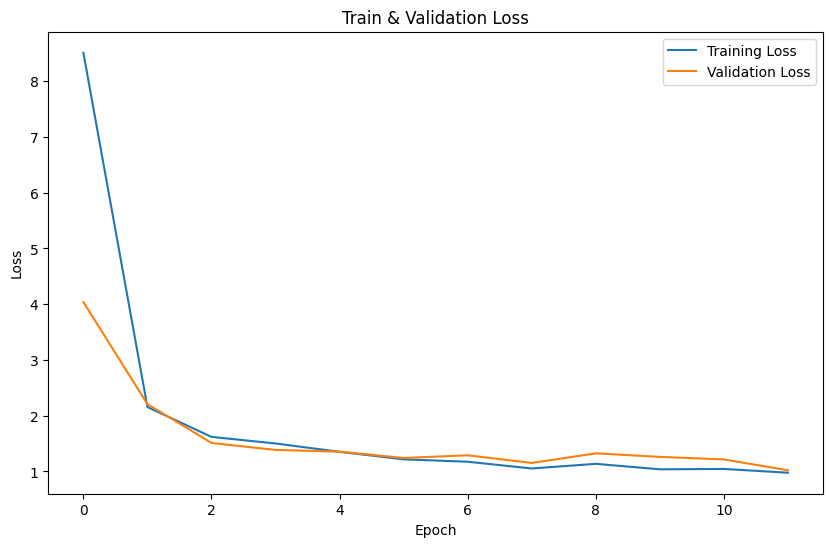

In [153]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    total_train_loss = 0
    total_val_loss = 0

    # Eğitim döngüsü
    for i in range(len(X_train)):
        with tf.GradientTape() as tape:
            y_pred = model(X_train[i:i+1], training=True)
            train_loss = loss_fn(y_train[i], y_pred[0, :len(y_train[i]), 0])
        gradients = tape.gradient(train_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        total_train_loss += train_loss.numpy()

    # Doğrulama döngüsü
    for i in range(len(X_val)):
        # X_val[i:i+1] dizisini tensöre dönüştür
        X_val_tensor = tf.convert_to_tensor(X_val[i:i+1], dtype=tf.float32)
        y_pred_val = model.predict(X_val_tensor)

        # y_val[i] dizisini tensöre dönüştür
        y_val_tensor = tf.convert_to_tensor(y_val[i], dtype=tf.float32)

        # Tahmin ve gerçek değerlerin boyutlarını eşitle
        min_length = min(y_pred_val.shape[1], len(y_val[i]))
        val_loss = loss_fn(y_val_tensor[:min_length], y_pred_val[0, :min_length, 0])

        total_val_loss += val_loss.numpy()

    # Ortalama kayıpları hesapla ve kaydet
    avg_train_loss = total_train_loss / len(X_train)
    avg_val_loss = total_val_loss / len(X_val)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_weights = model.get_weights()

    print(f"Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")


if best_weights:
    model.set_weights(best_weights)

# Kayıpları grafik üzerinde görselleştirme
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


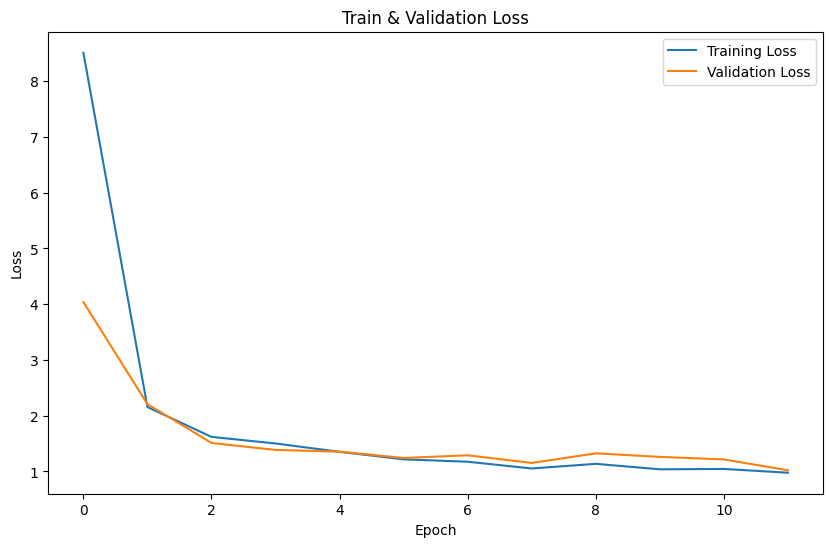

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [157]:
# Test veri seti üzerinde tahmin yapma
y_pred = model.predict(X_test)


4/4 [==============================] - 0s 12ms/step


In [158]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
def calculate_metrics(y_true, y_pred):
    mse_values = []
    mae_values = []
    r2_values = []

    for i in range(len(y_true)):
        true_values = np.array(y_true[i])
        pred_values = y_pred[i, :len(y_true[i]), 0]

        mse = mean_squared_error(true_values, pred_values)
        mae = mean_absolute_error(true_values, pred_values)

        mse_values.append(mse)
        mae_values.append(mae)

        # R2 skorunu yalnızca birden fazla değeri olan örnekler için hesap
        if len(true_values) > 1:
            r2 = r2_score(true_values, pred_values)
            r2_values.append(r2)

    return np.mean(mse_values), np.mean(mae_values), np.mean(r2_values) if r2_values else np.nan

# Hata metriklerini hesaplama
mse, mae, r2 = calculate_metrics(y_test, y_pred)

print("Mean Squared Error:", "{:.2f}".format(mse))
print("Mean Absolute Error:", "{:.2f}".format(mae))
print("R2 Score:", "{:.2f}".format(r2))


Mean Squared Error: 0.83
Mean Absolute Error: 0.66
R2 Score: 0.62


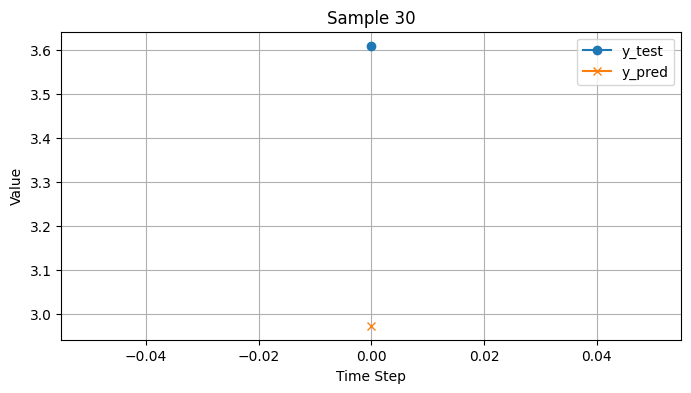

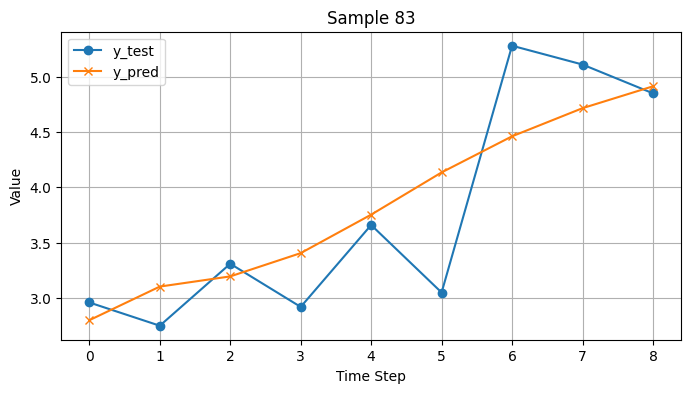

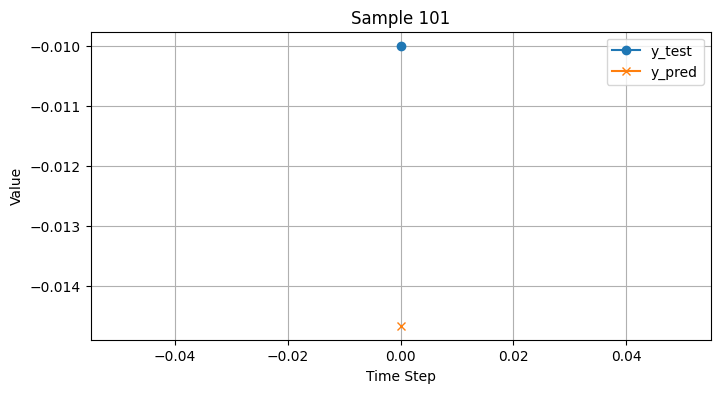

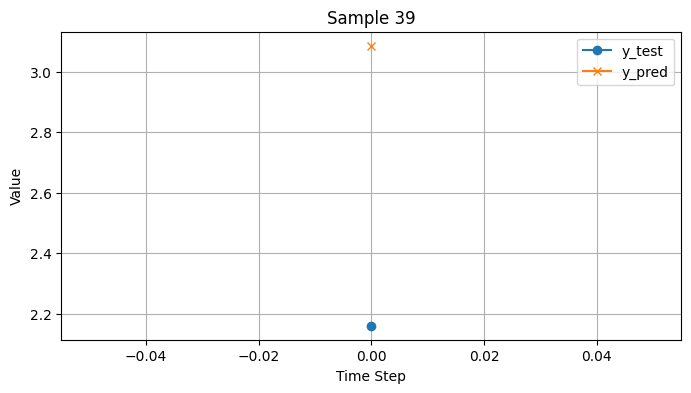

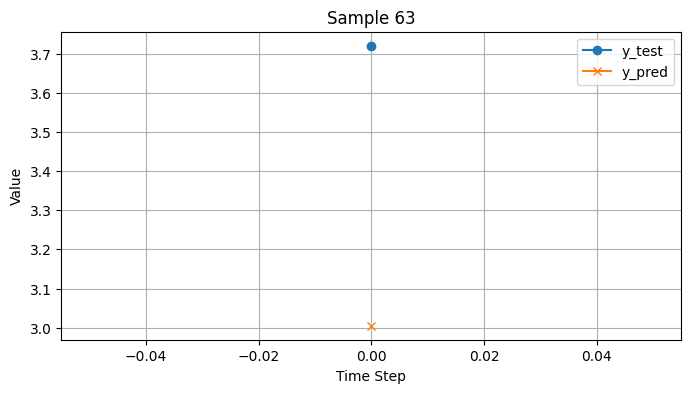

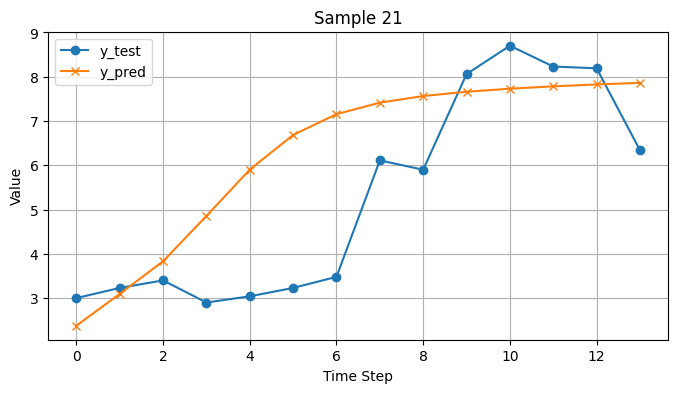

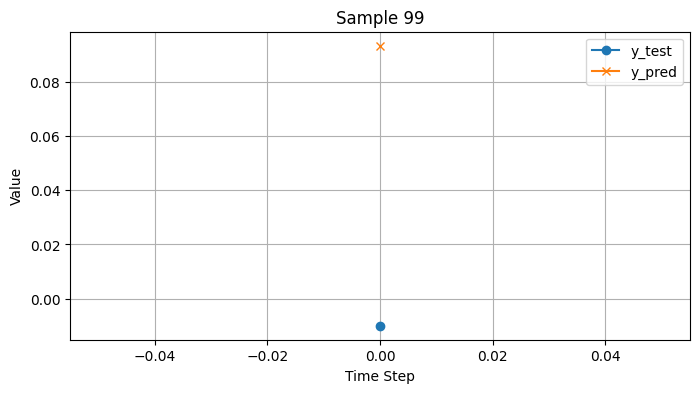

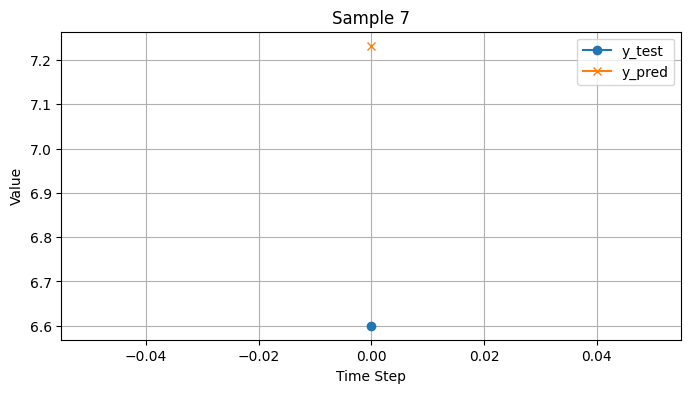

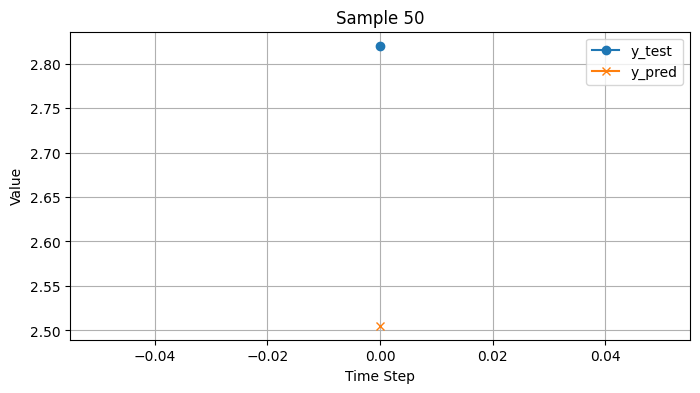

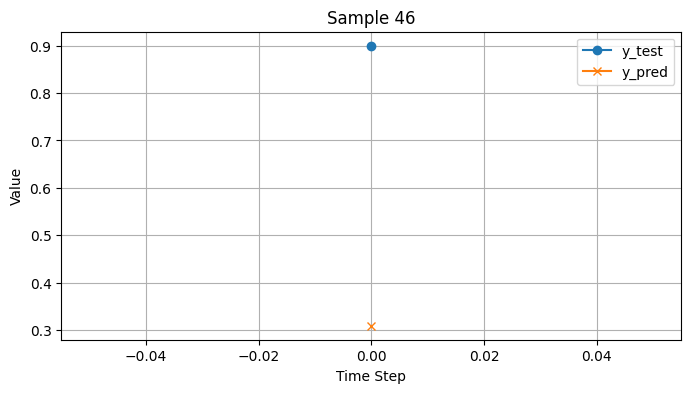

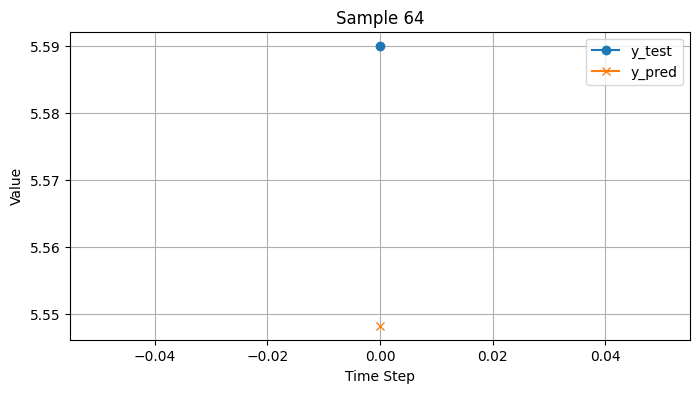

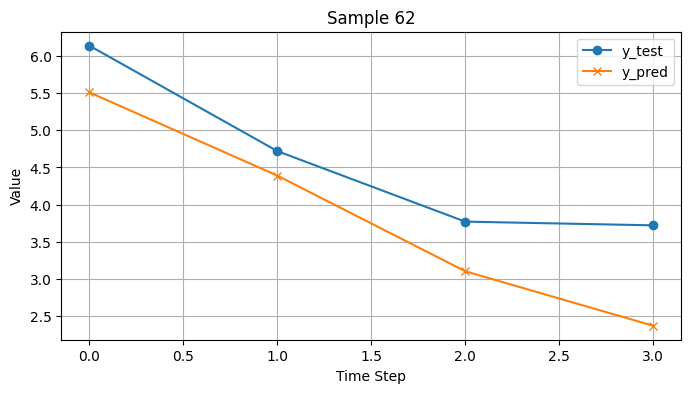

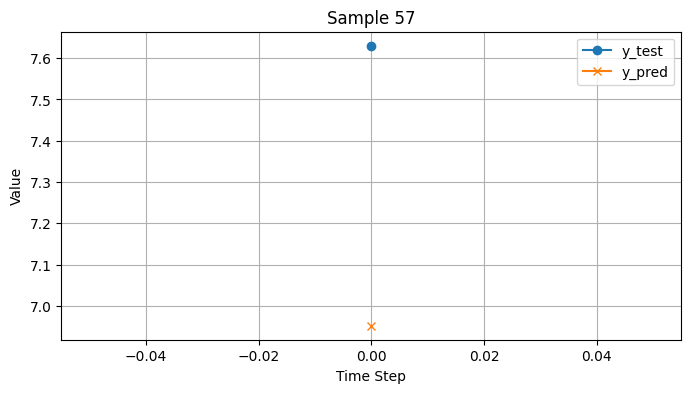

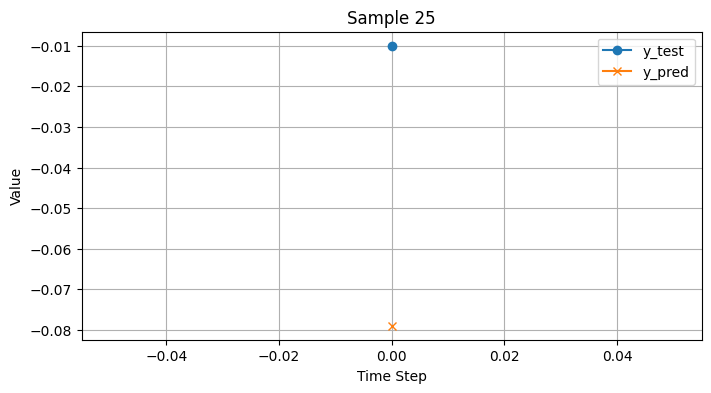

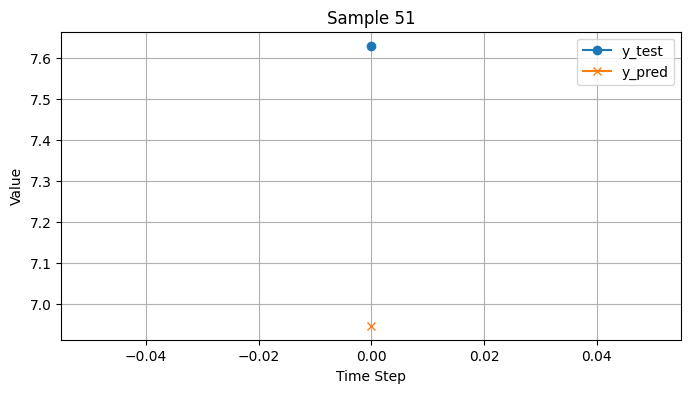

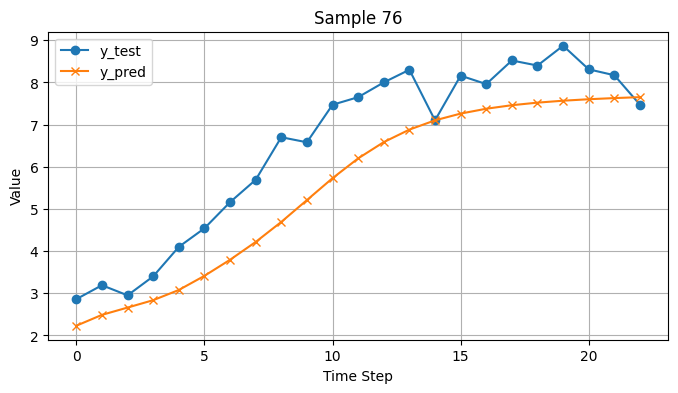

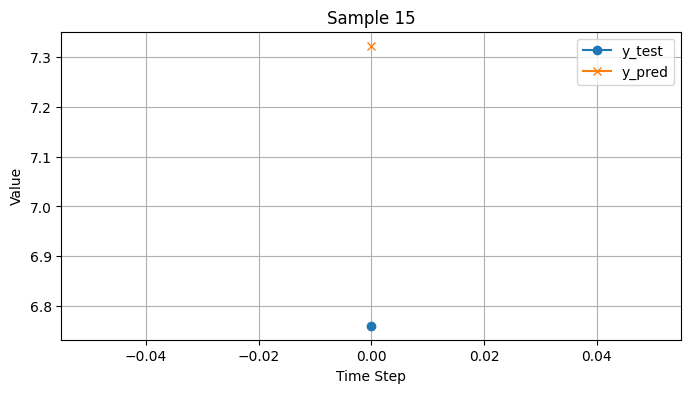

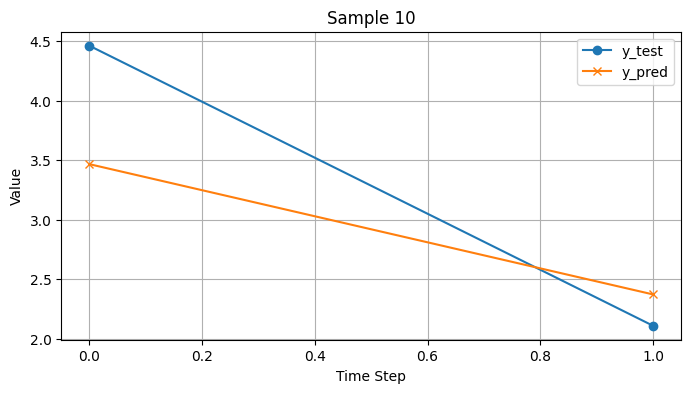

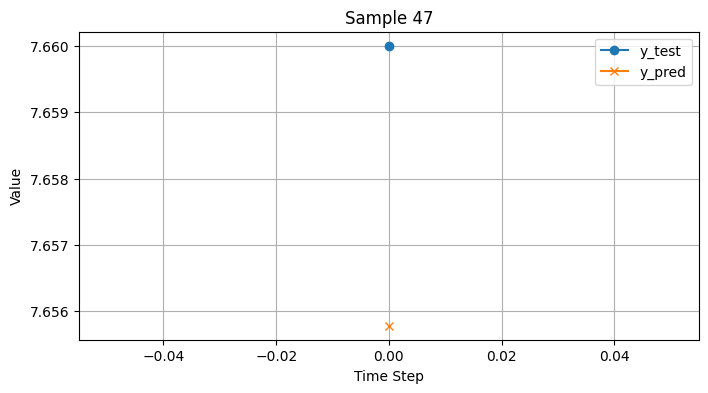

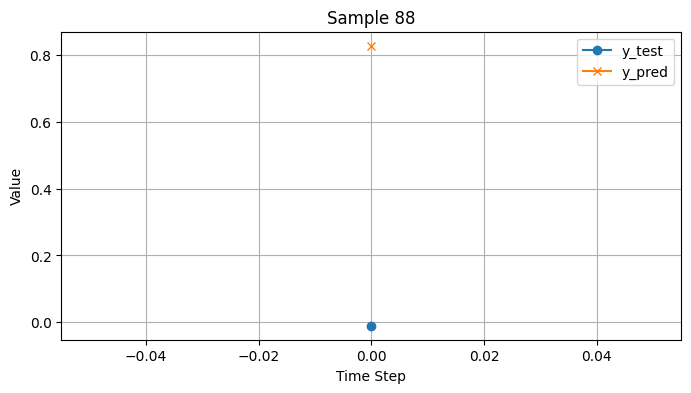

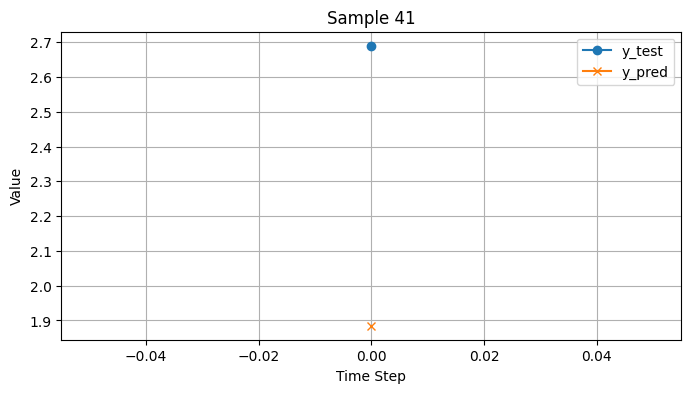

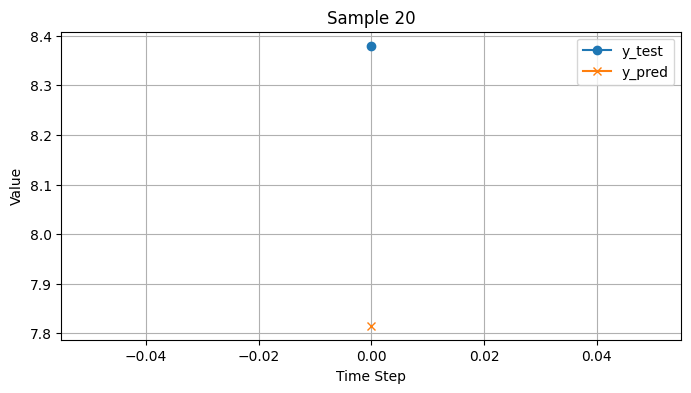

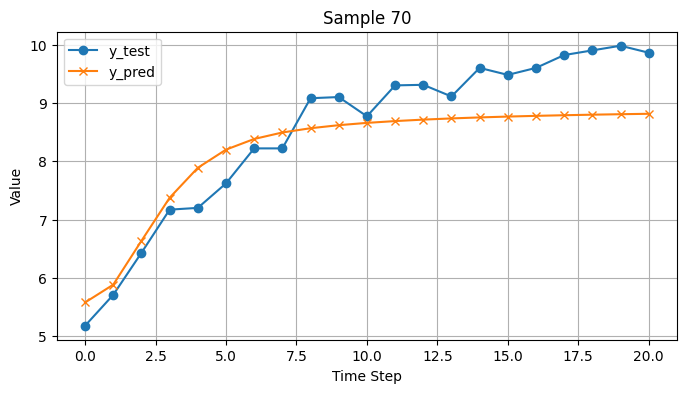

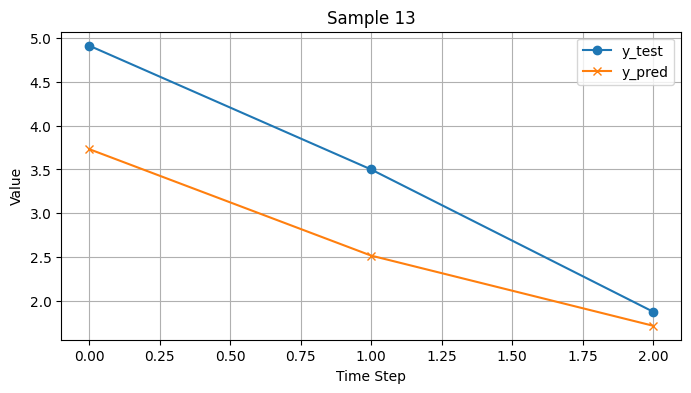

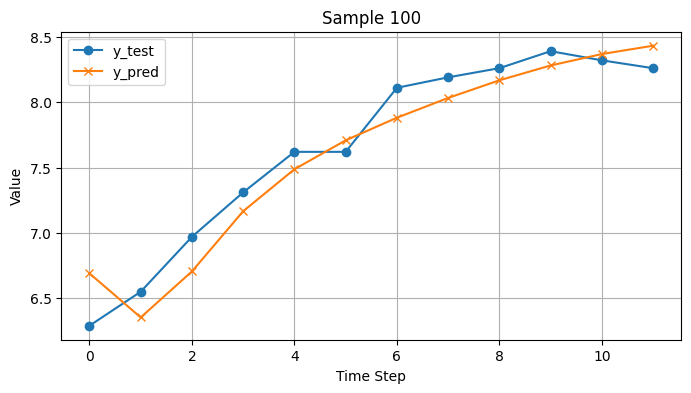

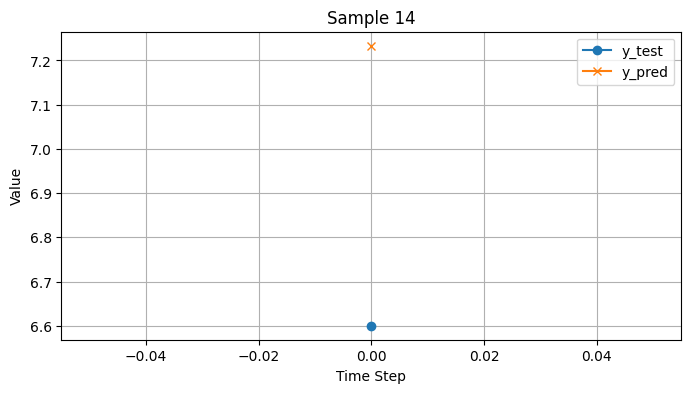

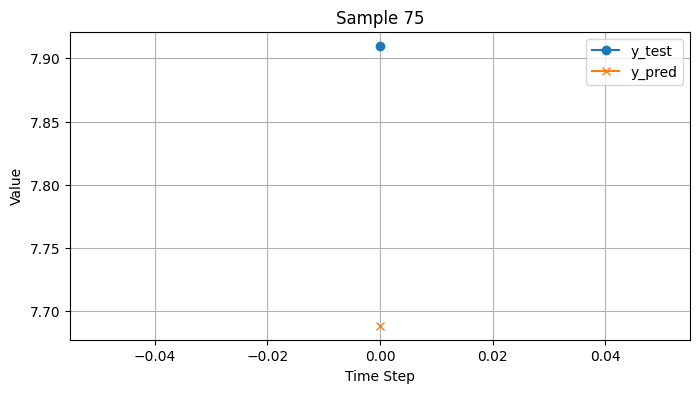

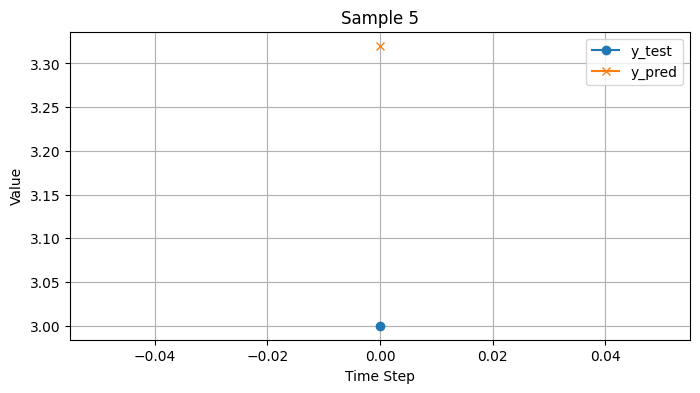

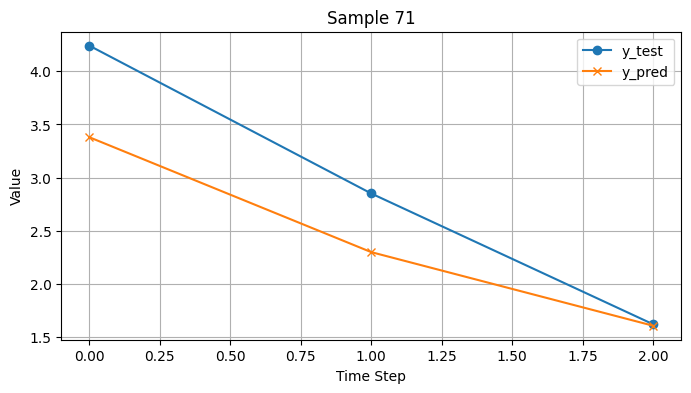

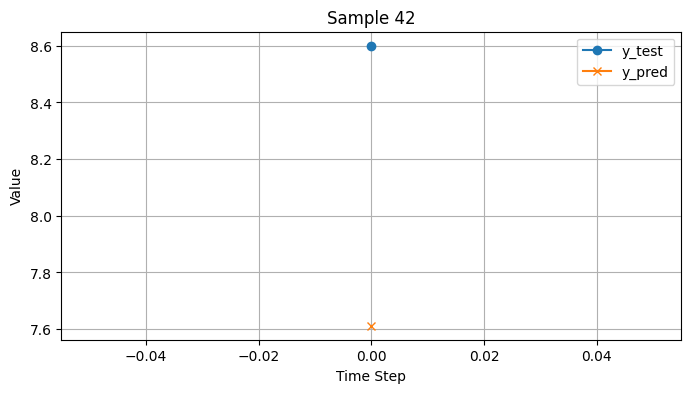

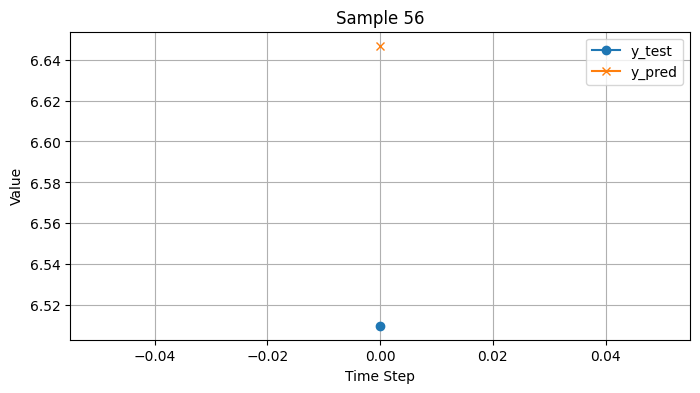

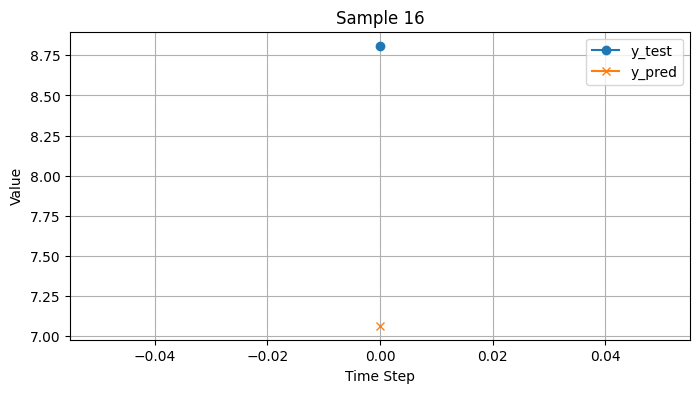

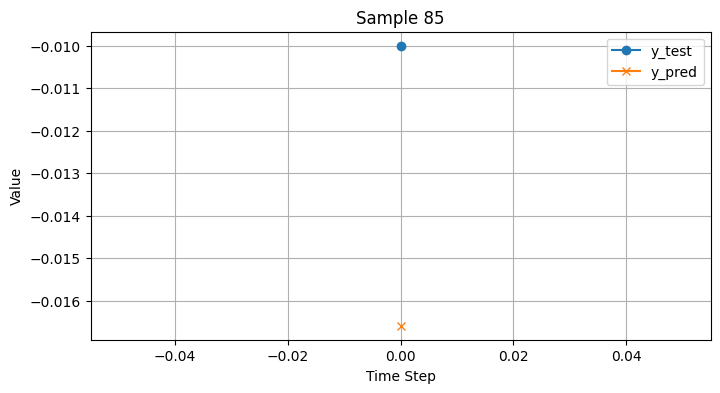

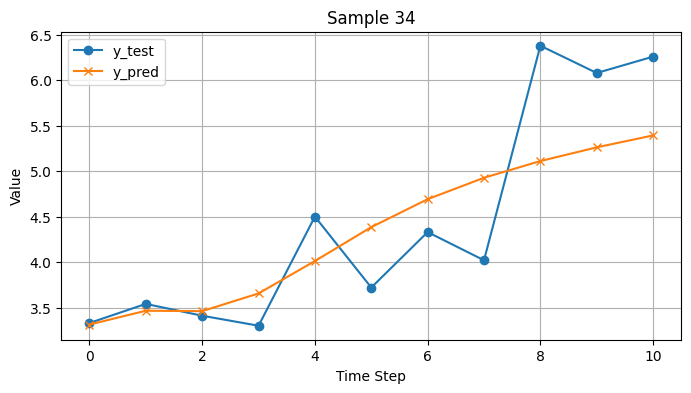

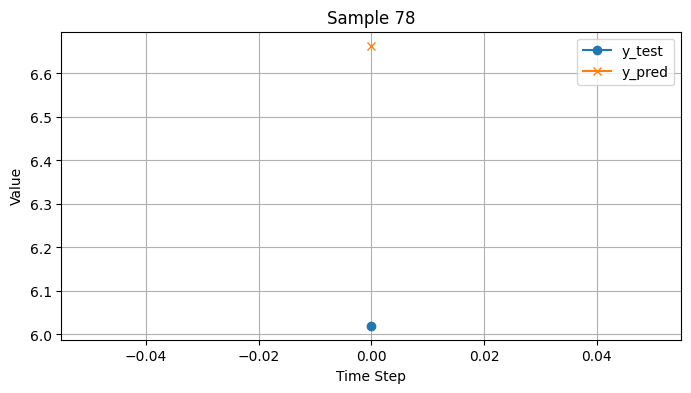

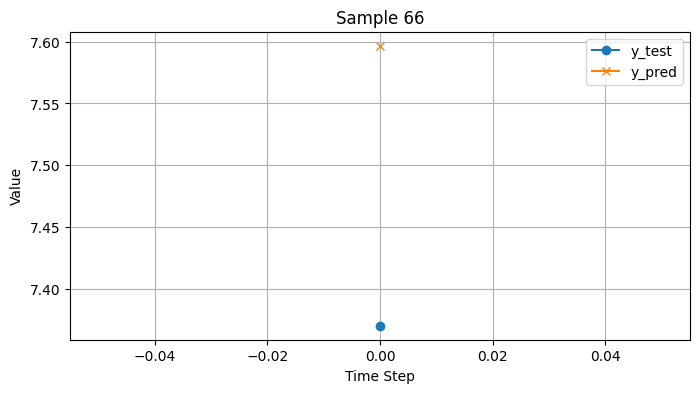

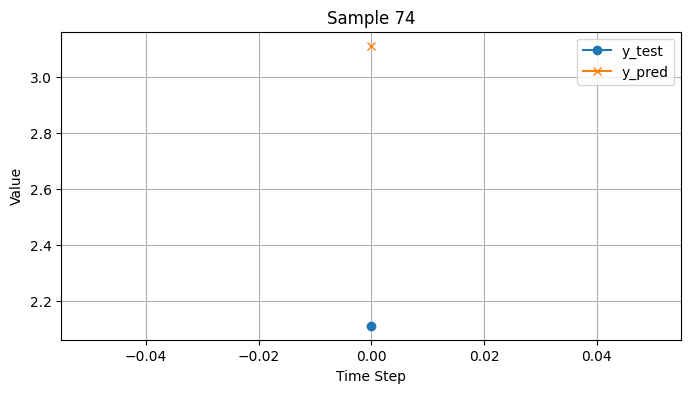

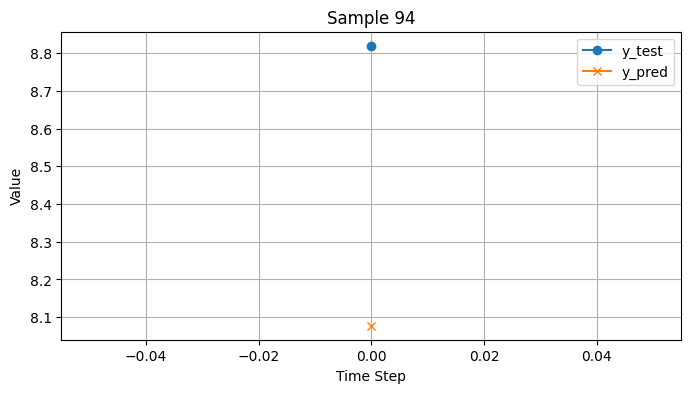

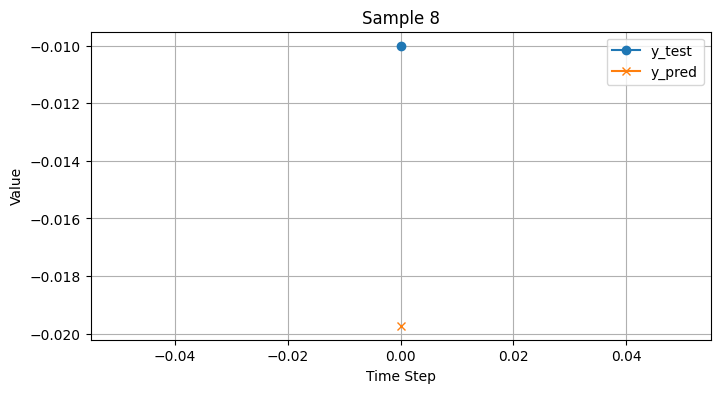

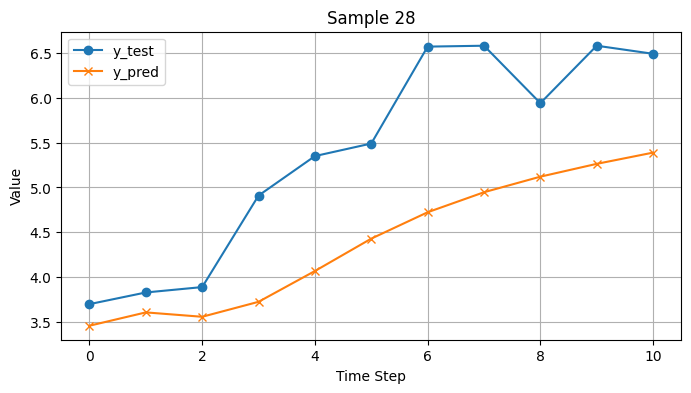

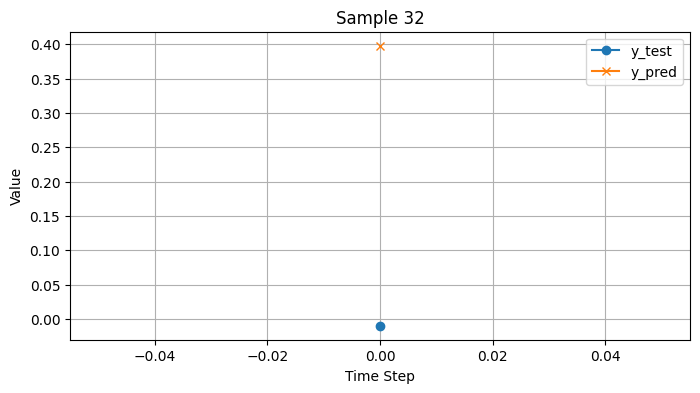

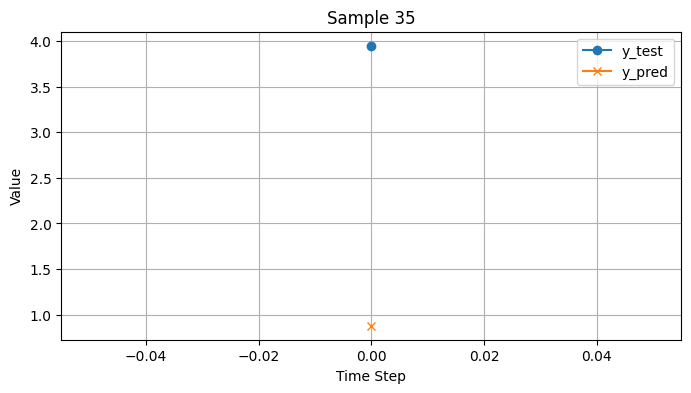

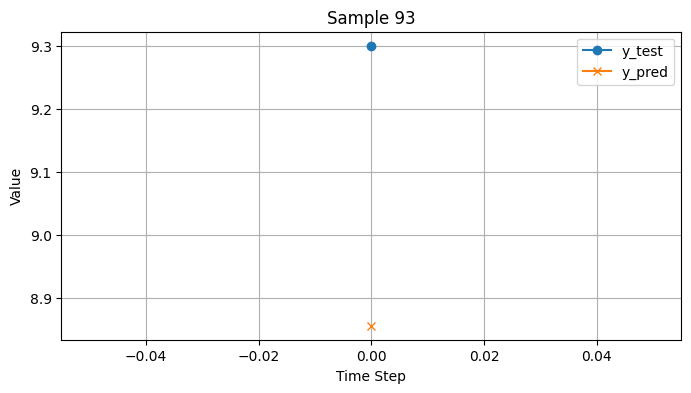

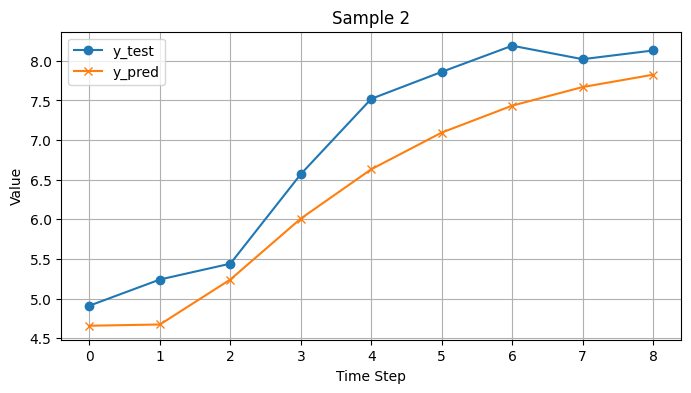

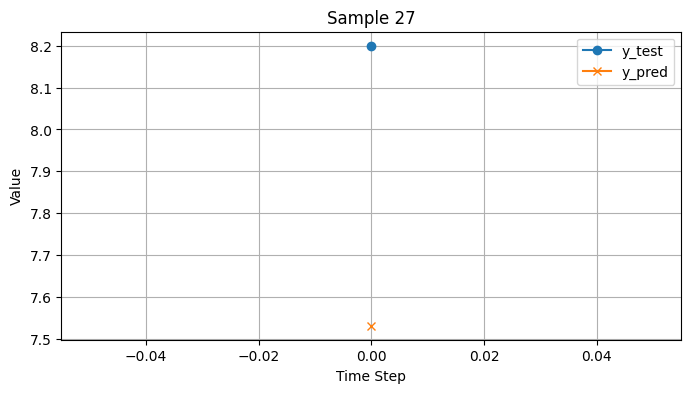

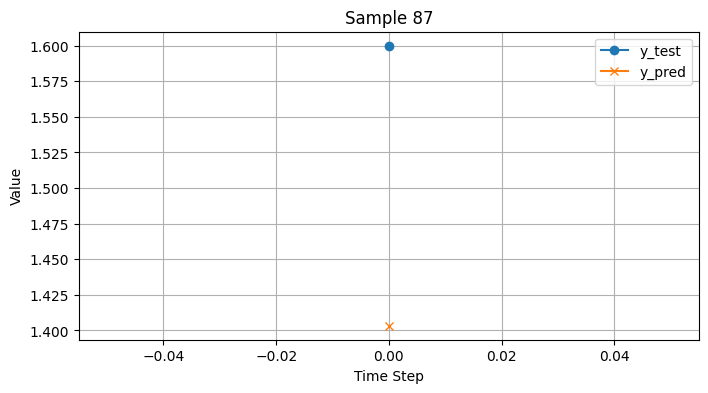

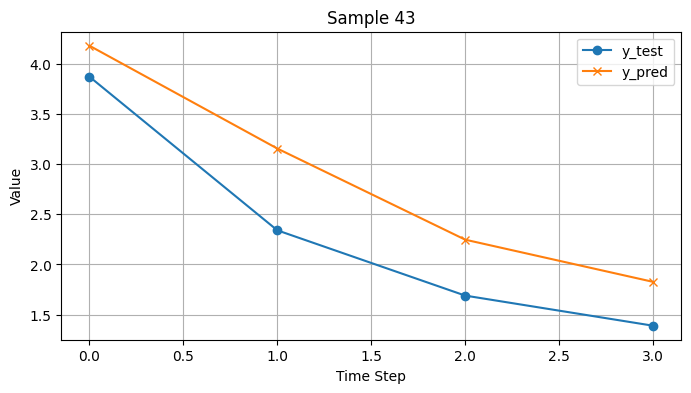

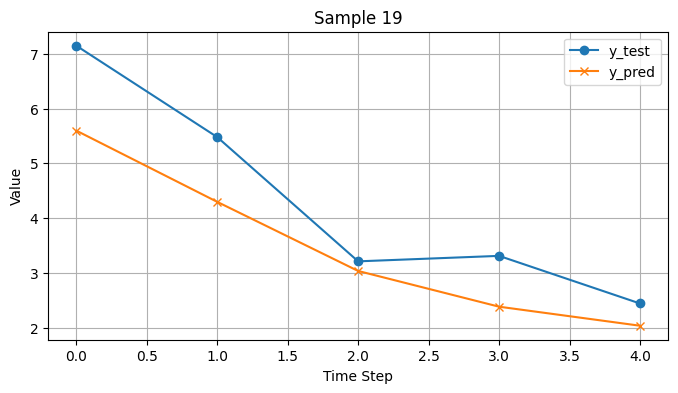

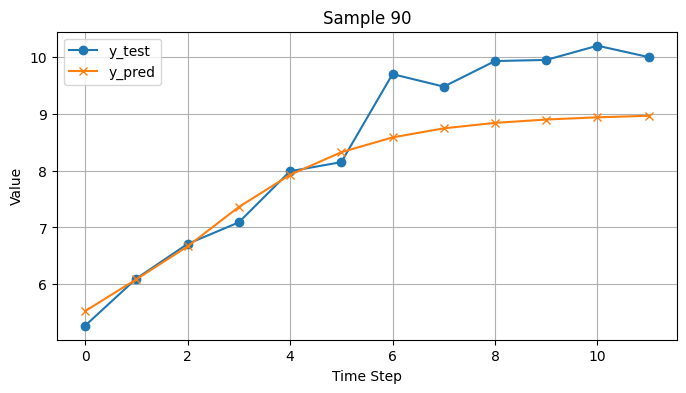

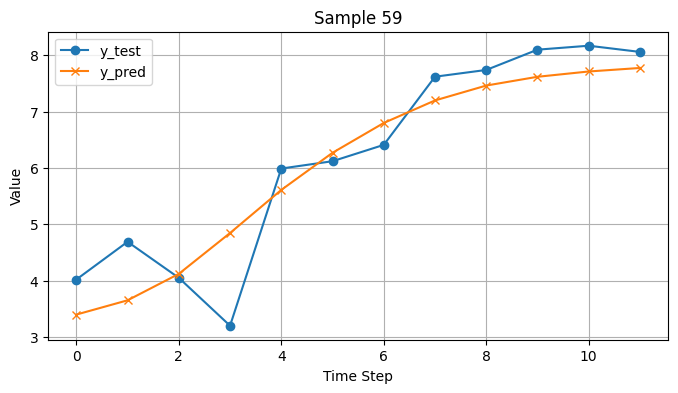

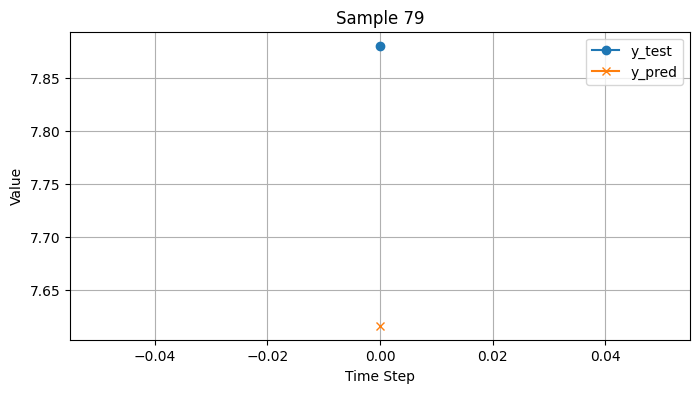

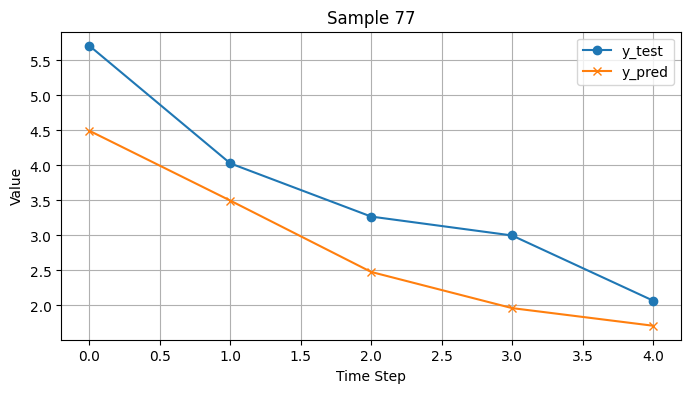

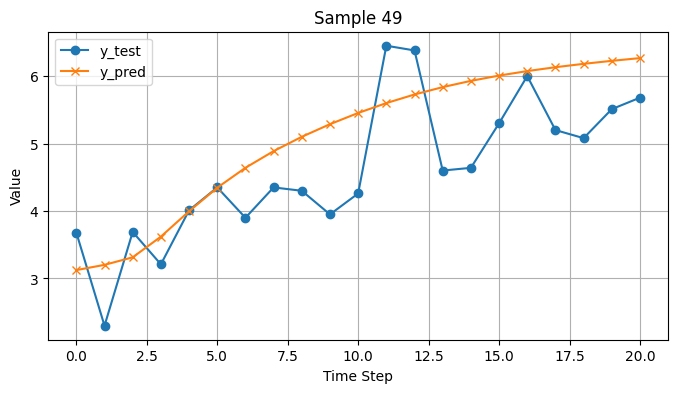

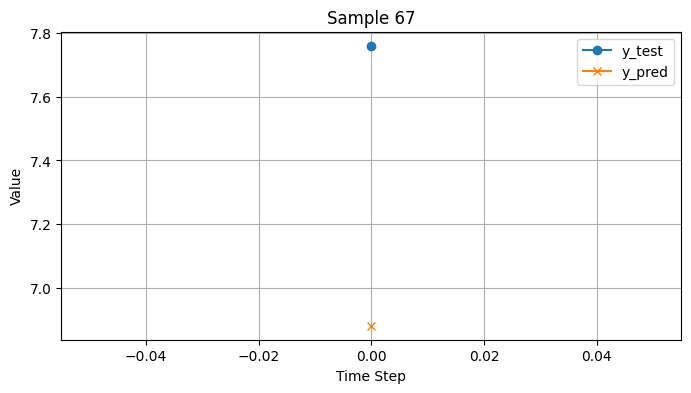

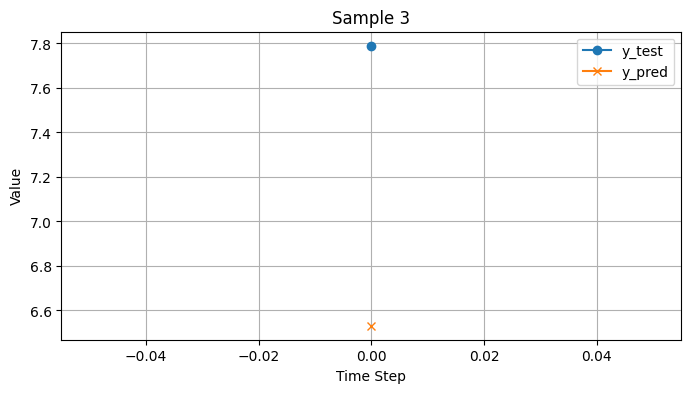

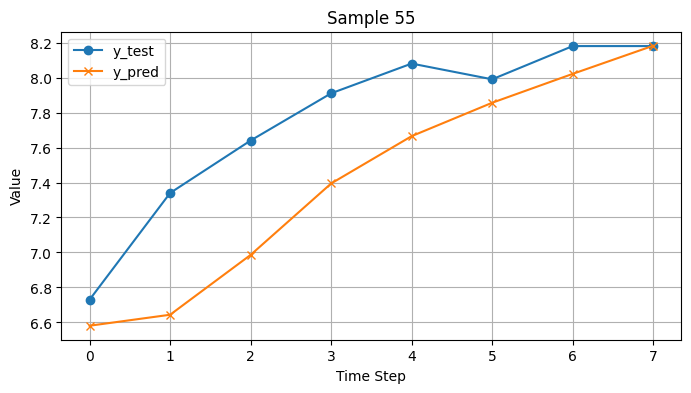

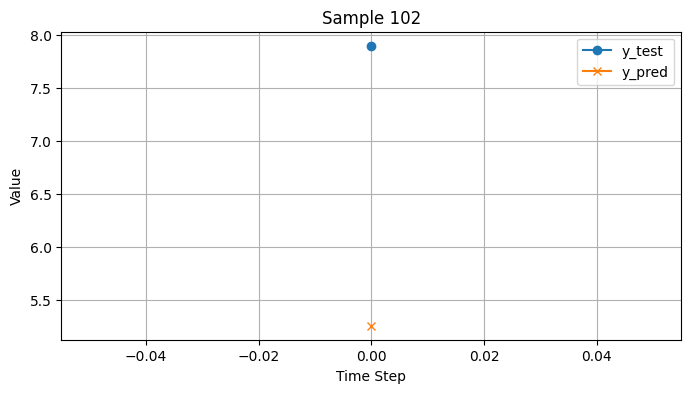

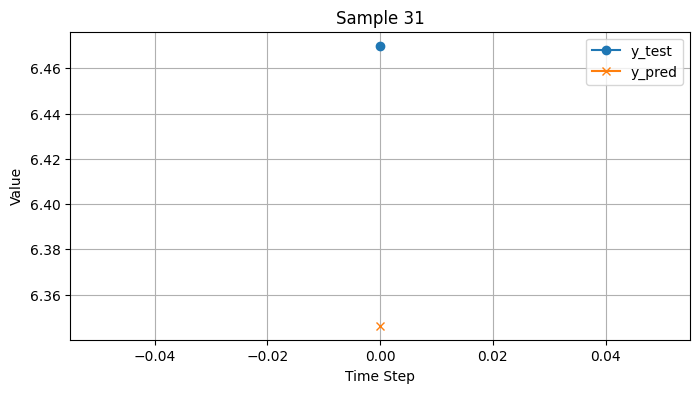

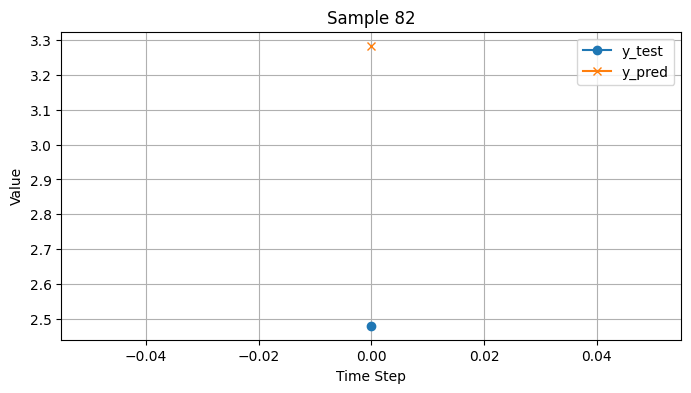

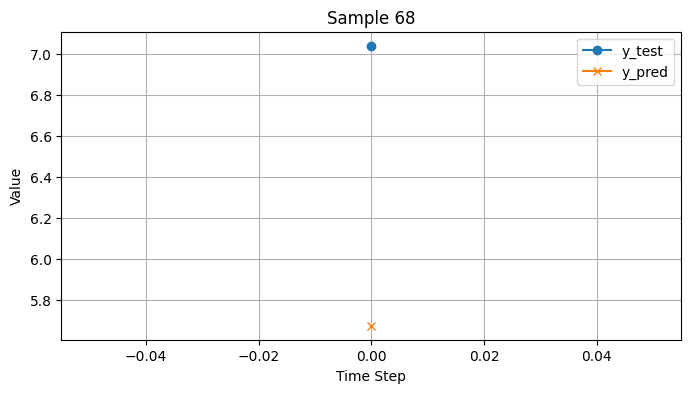

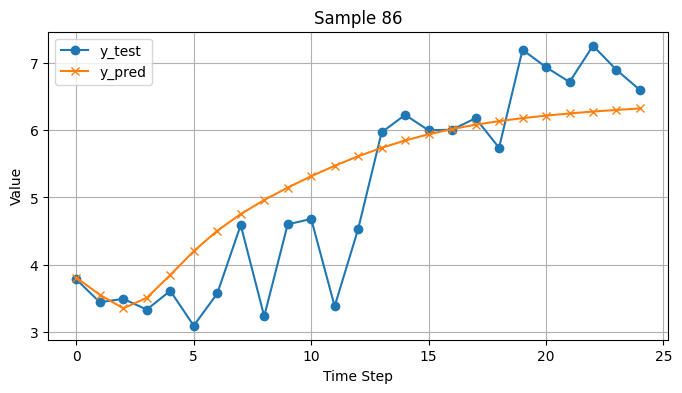

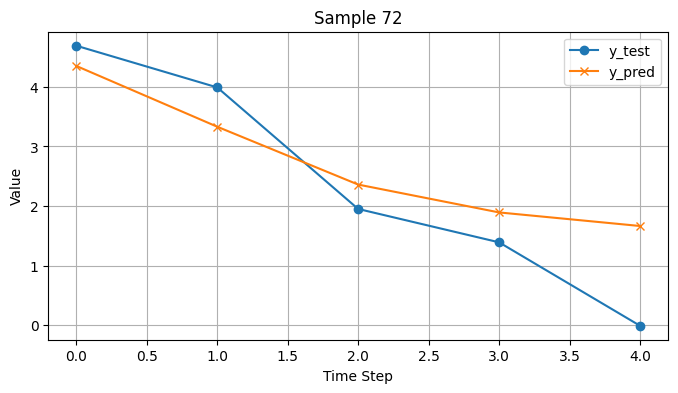

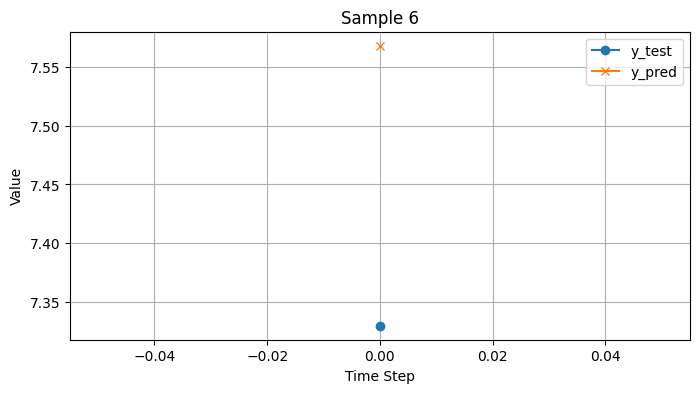

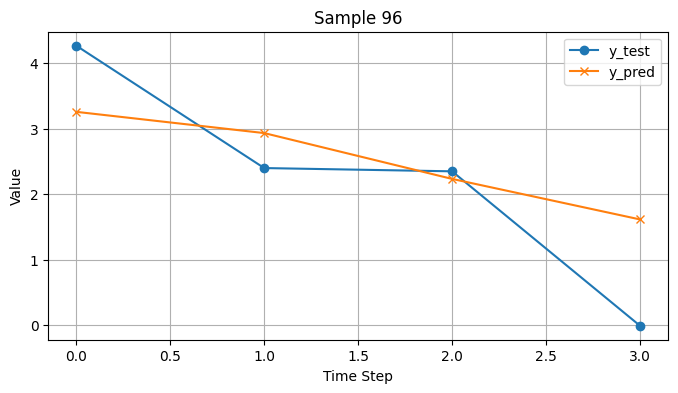

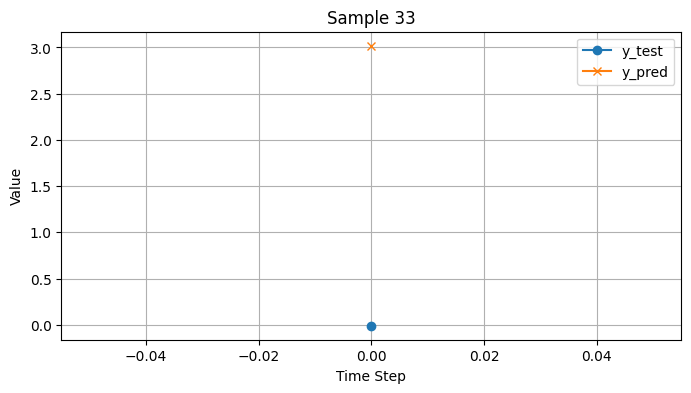

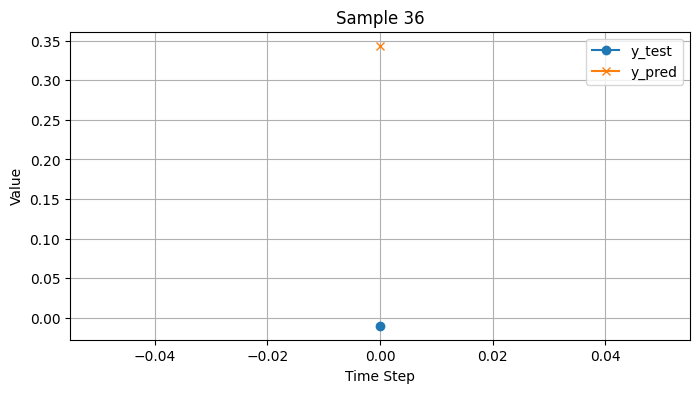

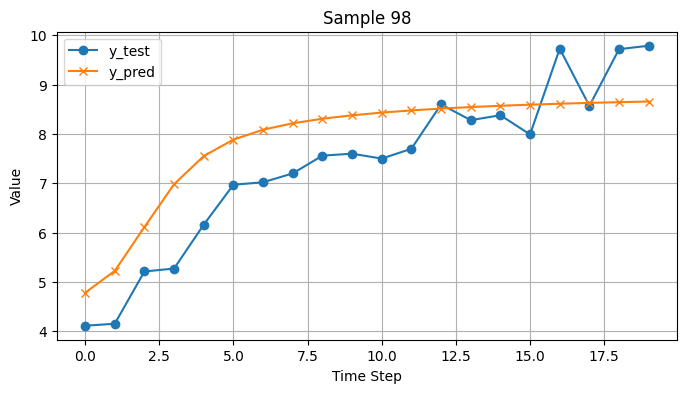

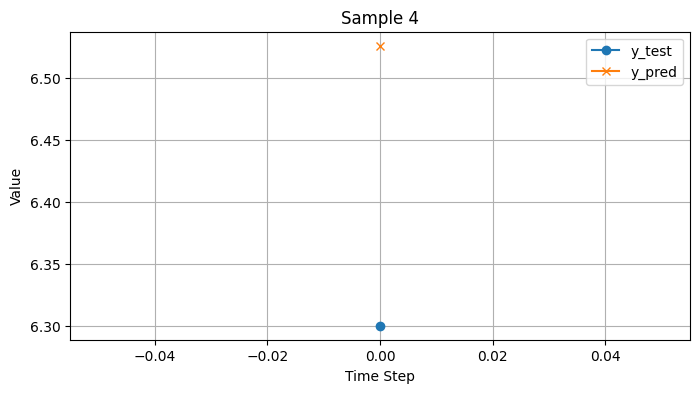

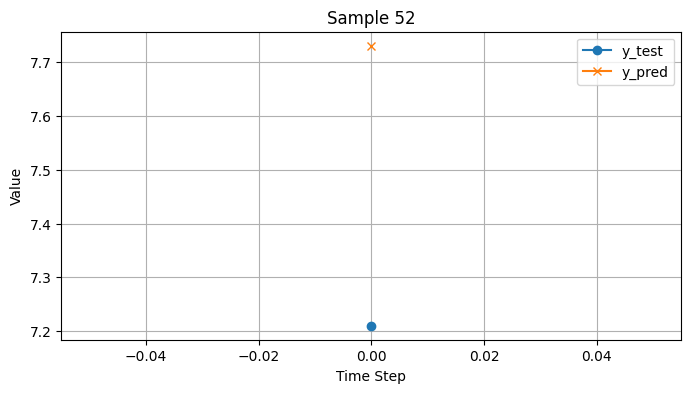

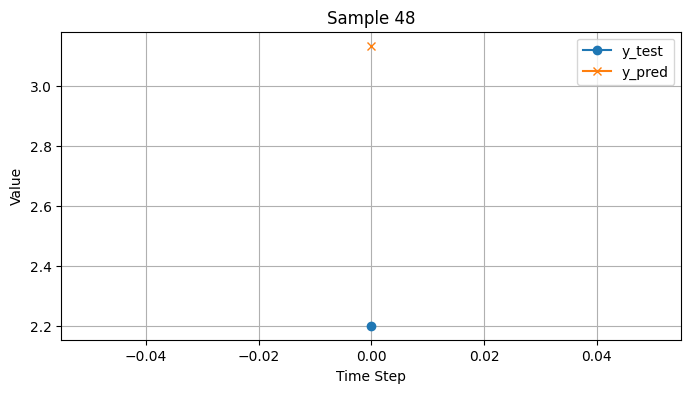

In [159]:
import matplotlib.pyplot as plt
import random

selected_indices = random.sample(range(len(y_test)), 70)

for index in selected_indices:
    plt.figure(figsize=(8, 4))  # Grafik boyutu
    plt.plot(y_test[index], marker='o', label='y_test')

    # y_pred verisini y_test verisinin uzunluğu
    y_pred_trimmed = y_pred[index][:len(y_test[index])]
    plt.plot(y_pred_trimmed, marker='x', label='y_pred')

    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.title(f'Sample {index + 1}')
    plt.show()

In [123]:
y_pred = model.predict(X_test)


4/4 [==============================] - 0s 10ms/step


## Anomaly Detection v2 BlackList

In [79]:

def calculate_metrics_by_id(y_true, y_pred, record_ids, r2_threshold):
    metrics_by_id = {}
    blacklist = []

    for i in range(len(y_true)):
        record_id = record_ids[i]
        true_values = np.array(y_true[i])
        pred_values = y_pred[i, :len(y_true[i]), 0]

        mse = mean_squared_error(true_values, pred_values)
        mae = mean_absolute_error(true_values, pred_values)
        r2 = r2_score(true_values, pred_values) if len(true_values) > 1 else np.nan

        metrics_by_id[record_id] = {'mse': mse, 'mae': mae, 'r2': r2}

        if r2 < r2_threshold:
            blacklist.append(record_id)

    return metrics_by_id, blacklist

total_sample=len(y_test)
# Hata metriklerini ve karalisteyi hesapla
r2_threshold = 0.3  # Örnek bir eşik değer
y_pred = model.predict(X_test)
metrics_by_id, blacklist = calculate_metrics_by_id(y_test, y_pred, record_ids_test, r2_threshold)

y_pred = model.predict(X_train)
total_sample+=len(y_train)
metrics_by_id2, blacklist2 = calculate_metrics_by_id(y_train, y_pred, record_ids_train, r2_threshold)

filtered_sample_count = total_sample - (len(blacklist) + len(blacklist2) )
filtered_sample_count
blacklistt = blacklist+blacklist2


11/11 [==============================] - 0s 14ms/step


In [80]:
print(filtered_sample_count)
print(len(blacklistt))
print(len(df))

409
17
508


In [81]:
import csv

with open('anomalies11.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for record_id in blacklistt:
        writer.writerow([record_id])


In [ ]:
filtered_sample_count

In [ ]:
len(y_pred)

In [ ]:
import matplotlib.pyplot as plt
import random

selected_indices = random.sample(range(len(y_test)),25)

for index in selected_indices:
    plt.figure(figsize=(8, 4))  # Grafik boyutu
    plt.plot(y_test[index], marker='o', label='y_test')

    # y_pred verisini y_test verisinin uzunluğu
    y_pred_trimmed = y_pred[index][:len(y_test[index])]
    plt.plot(y_pred_trimmed, marker='x', label='y_pred')

    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.title(f'Sample {index + 1}')
    plt.show()

In [ ]:
len(df)

In [ ]:
model.save('encoder_decoder_model.h5')


In [ ]:
def calculate_metrics_and_blacklist(df, y_true, y_pred, r2_threshold):
    mse_values = []
    mae_values = []
    r2_values = []
    blacklist = []

    for i, (index, row) in enumerate(df.iterrows()):
        record_id = row['Record ID']
        true_values = np.array(y_true[i])
        pred_values = y_pred[i, :len(y_true[i]), 0]

        if len(true_values) > len(pred_values):
            true_values = true_values[:len(pred_values)]

        mse = mean_squared_error(true_values, pred_values)
        mae = mean_absolute_error(true_values, pred_values)
        mse_values.append(mse)
        mae_values.append(mae)

        if len(true_values) > 1:
            r2 = r2_score(true_values, pred_values)
            r2_values.append(r2)
            if r2 < r2_threshold:
                blacklist.append(record_id)

    return np.mean(mse_values), np.mean(mae_values), np.mean(r2_values), blacklist

# Hata metriklerini ve karalisteyi hesapla
r2_threshold = 0.5  # Örnek bir eşik değer
mse, mae, r2, blacklist = calculate_metrics_and_blacklist(df, y_train, y_pred, r2_threshold)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)
print("Blacklisted Record IDs:", blacklist)
